## What is this file?

This file is a storehouse for our work that did not make it into our final submitted model. We approached the Random Acts of Pizza challenge from many angles and you'll find several of those approaches below. We hope it will provide additional context around how we thought through the challenge and some of the things we learned through this process.

-------------------------------------------------------

In [1]:
# For figures to show inline
%matplotlib inline

## Import Libraries ##

import json
from pprint import pprint
from pandas.io.json import json_normalize
import pandas as pd

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mlxtend
import scipy
import datetime as dt
from itertools import product

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for pre/processing data
from sklearn import preprocessing

# NLTK for text processing, analyzing tools
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.util import *

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# SK-lear library for feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import EnsembleVoteClassifier

# SK-learn libraries for evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, recall_score


In [2]:
## Get Data ##

# Reference for data: https://www.kaggle.com/c/random-acts-of-pizza/data
# Pull in the training and test data
with open('data/train.json', encoding='utf-8') as data_file:
    trainData = json.loads(data_file.read())   

with open('data/test.json', encoding='utf-8') as data_file:
    testData = json.loads(data_file.read())    

# create a dev data set 
devData = trainData[0:1000]
trainData = trainData[1000:]

# show how the data looks in its original format
#pprint("data in json format:")
#pprint(trainData[1])

# create a normalized view
allTData = json_normalize(trainData)
print("\nSize of the normalized Data:", allTData.shape)
print("\nnormalized data columns:", list(allTData))

allDData = json_normalize(devData)


Size of the normalized Data: (3040, 32)

normalized data columns: ['giver_username_if_known', 'number_of_downvotes_of_request_at_retrieval', 'number_of_upvotes_of_request_at_retrieval', 'post_was_edited', 'request_id', 'request_number_of_comments_at_retrieval', 'request_text', 'request_text_edit_aware', 'request_title', 'requester_account_age_in_days_at_request', 'requester_account_age_in_days_at_retrieval', 'requester_days_since_first_post_on_raop_at_request', 'requester_days_since_first_post_on_raop_at_retrieval', 'requester_number_of_comments_at_request', 'requester_number_of_comments_at_retrieval', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_comments_in_raop_at_retrieval', 'requester_number_of_posts_at_request', 'requester_number_of_posts_at_retrieval', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_on_raop_at_retrieval', 'requester_number_of_subreddits_at_request', 'requester_received_pizza', 'requester_subreddits_at_request

### Section 1: Setting Up & Processing Data

(3040, 1)

Percent of people who got pizza: 0.241


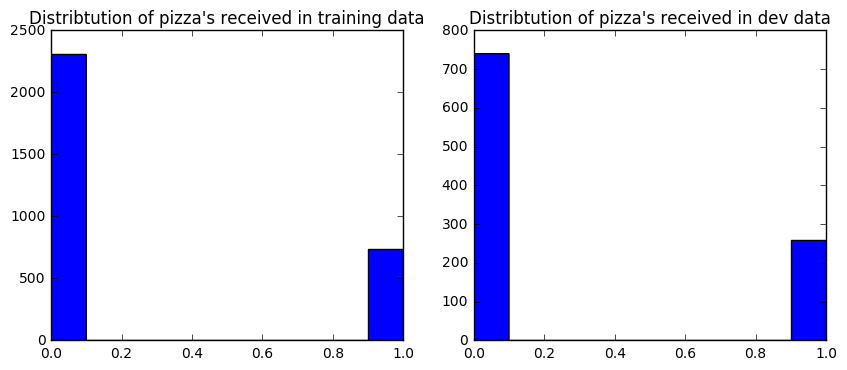

In [3]:
## Create subsets of data for analysis ###

# Create a flat dataset without the subreddits list
flatData = allTData.drop('requester_subreddits_at_request', 1)
# Create a separate dataset with just subreddits, indexed on request id
# We can creata a count vector on the words, run Naive Bayes against it, 
# and add the probabilities to our flat dataset
subredTData = allTData[['request_id','requester_subreddits_at_request']]
subredTData.set_index('request_id', inplace=True)

subredDData= allDData[['request_id','requester_subreddits_at_request']]
subredDData.set_index('request_id', inplace=True)

# our training labels
trainLabel = allTData['requester_received_pizza']

devLabel = allDData['requester_received_pizza']

# What do these look like?
#print(list(flatData))
print(subredTData.shape)
#print(subredTData['requester_subreddits_at_request'][1])

# Create a corpus of subreddits to vectorize
trainCorpus = []
rTCorpus = []
rDCorpus = []

for index in range(len(subredTData)):
    trainCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))
    rTCorpus.append(' '.join(subredTData['requester_subreddits_at_request'][index]))

devCorpus = []
for index in range(len(subredDData)):
    devCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))
    rDCorpus.append(' '.join(subredDData['requester_subreddits_at_request'][index]))

# Baseline infofrom mlxtend.plotting import plot_decision_regions
print("\nPercent of people who got pizza:", round(sum(trainLabel)/len(trainLabel),3))

plt.figure(1,figsize=(10,4))
plt.subplot(121)
plt.hist(allTData['requester_received_pizza'])
plt.title("Distribtution of pizza's received in training data")
plt.subplot(122)
plt.hist(allDData['requester_received_pizza'])
plt.title("Distribtution of pizza's received in dev data")

In [4]:
# Useful functions for analysis
def roc_curve1(y_true, y_pred_prob):
    """This function plots the ROC curve
    Inputs: y_true, correct label
            y_pred_prob, predicted probabilities
    """
    fpr, tpr, thr = roc_curve(y_true, y_pred_prob)
   
    plt.figure()
    plt.plot(fpr,tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC Curve")
    plt.show()
    

def score_rep(y_true, y_pred, desc):
    """Function to print out comprehensive report for classification test
    Inputs: y_true, correct label
            y_pred, predicted label from model
            desc, description of model
    Output: classification report
    """
    print(desc)
    print("-"*75)
    print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
    print("Area under curve of ROC: ", metrics.roc_auc_score(y_true, y_pred))
    print("Classification report:\n")
    print(metrics.classification_report(y_true, y_pred))
    print("-"*75)
    


### vaderSentiment Analysis

In [5]:
# Quick learning exercise to figure out how
# to get vaderSentiment to work

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
test = "It was one of the worst movies I've seen, despite good reviews."

def print_sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))
    print(snt['compound'])

print_sentiment_scores("It was one of the worst movies I've seen, despite good reviews.")

#sentences = "VADER is smart, handsome, and funny."

#print_sentiment_scores(sentences)

sentences = ["VADER is smart, handsome, and funny.", "VADER is silly, ugly, and rude!"]

for sentence in sentences:
    print("\n")
    print(sentence)
    vs = print_sentiment_scores(sentence)


It was one of the worst movies I've seen, despite good reviews. {'pos': 0.0, 'compound': -0.7584, 'neu': 0.606, 'neg': 0.394}
-0.7584


VADER is smart, handsome, and funny.
VADER is smart, handsome, and funny.---- {'pos': 0.746, 'compound': 0.8316, 'neu': 0.254, 'neg': 0.0}
0.8316


VADER is silly, ugly, and rude!
VADER is silly, ugly, and rude!--------- {'pos': 0.103, 'compound': -0.7574, 'neu': 0.281, 'neg': 0.617}
-0.7574


In [6]:
# Setting up for Titles

title = allTData[['request_title', 'requester_received_pizza']].copy()
title.columns = ['Title', 'Got Pizza']
print("\n")
print("Titles and Pizza Success\n")
print(title.head(10))
pizza_title = title.groupby(['Got Pizza'])
print("\n")





Titles and Pizza Success

                                               Title Got Pizza
0  [Request] Just got dumped, no food in the free...     False
1  [Request]  Saint Augustine, US.  Boyfriend and...     False
2        [Request] I'd love a Buffalo Chicken Puzza!      True
3  [REQUEST]- I start class next week and i am st...     False
4        [Request] Pizza for finals in Northern Iowa      True
5      [request]lovepark,il. Preggers and very sad..     False
6  [Request] My friend is letting me stay with hi...     False
7  [Request] Painting our apartment today, would ...     False
8  [REQUEST] Pennsylvania, USA living off PB&amp;...     False
9          [Request] UK - Broke Student Exam Special      True




In [7]:
#Train Data Sentiment Analysis
import pandas as pd

titles = allTData['request_title']

df = pd.DataFrame(data = allTData)

#combing request title and Y variable
df = df[['request_title', 'requester_received_pizza']]

    
scores = []

for title in titles:
    scores.append(analyser.polarity_scores(title)['compound'])


df["Vader Scores"] = scores

df = df.drop('request_title', axis = 1)
# print the y variable and sentiment score
print(df)


     requester_received_pizza  Vader Scores
0                       False       -0.5994
1                       False        0.2263
2                        True        0.6696
3                       False        0.2960
4                        True        0.0000
5                       False        0.0000
6                       False        0.4588
7                       False        0.6369
8                       False        0.0000
9                        True       -0.0258
10                      False        0.5106
11                      False       -0.3400
12                      False       -0.7650
13                      False        0.0000
14                      False        0.0000
15                      False       -0.4926
16                       True        0.0000
17                      False        0.5562
18                      False       -0.4998
19                      False        0.5859
20                       True        0.6757
21                      False   

In [8]:
#Dev Data Sentiment Analysis
import pandas as pd

titles = allDData['request_title']

df_d = pd.DataFrame(data = allDData)

df_d = df_d[['request_title', 'requester_received_pizza']]

    
scores_d = []

for title in titles:
    scores_d.append(analyser.polarity_scores(title)['compound'])

df_d["Vader Scores"] = scores_d

df_d = df_d.drop('request_title', axis = 1)

print(df_d)



    requester_received_pizza  Vader Scores
0                      False        0.6124
1                      False       -0.2960
2                      False        0.6696
3                      False        0.0000
4                      False        0.8455
5                       True        0.0000
6                      False        0.4019
7                      False        0.0000
8                      False       -0.3862
9                       True        0.0000
10                      True        0.4939
11                     False        0.6369
12                     False        0.7430
13                     False       -0.4215
14                     False        0.0000
15                     False        0.0000
16                      True       -0.0772
17                     False       -0.4215
18                      True        0.1280
19                     False       -0.2500
20                     False        0.7959
21                     False       -0.7269
22         

In [9]:
# sentiment logistic regression accuracy
import pandas as pd

tTitles = allTData['request_title']
dTitles = allDData['request_title']

titleTSentiment = []
titleDSentiment = []

for title in tTitles:
    snt = analyser.polarity_scores(title)
    compoundScore = snt['compound']
    titleTSentiment.append(compoundScore)

titleTSentiment = pd.DataFrame(titleTSentiment)
    
for title in dTitles:
    snt = analyser.polarity_scores(title)
    compoundScore = snt['compound']
    titleDSentiment.append(compoundScore)

titleDSentiment = pd.DataFrame(titleDSentiment)

C = 100
modelLogit = LogisticRegression(penalty = 'l2', C = C)

trainLabel = allTData['requester_received_pizza']
devLabel = allDData['requester_received_pizza']

modelLogit.fit(titleTSentiment,trainLabel)
score_rep(devLabel,modelLogit.predict(titleDSentiment),'Logistic Regression, C = 0.001')


Logistic Regression, C = 0.001
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------


/Users/erikaananda/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Reducing vocabulary (doesn't work)



Logistic Regression f1-score with C =  0.100:
0.0
Number of non-zero elements: 26
Vocabulary size: 26


/Users/erikaananda/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Logistic Regression (using l2) f1-score with C =  0.100:
0.00766283524904
Logistic Regression
---------------------------------------------------------------------------
Accuracy:  0.741
Area under curve of ROC:  0.501923076923
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       1.00      0.00      0.01       260

avg / total       0.81      0.74      0.63      1000

---------------------------------------------------------------------------

Logistic Regression f1-score with C =  1.000:
0.204081632653
Number of non-zero elements: 740
Vocabulary size: 740

Logistic Regression (using l2) f1-score with C =  1.000:
0.220289855072
Logistic Regression
---------------------------------------------------------------------------
Accuracy:  0.731
Area under curve of ROC:  0.54132016632
Classification report:

             precision    recall  f1-score   support

      False       0.76      0.94    

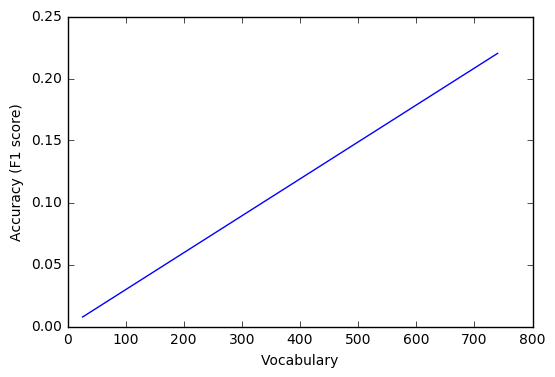

In [10]:

# Keep this random seed here to make comparison easier.
np.random.seed(101)

### STUDENT START ###

# Countvectorizer options: turns on lower case, strip accents, and stop-words
vectorizer = CountVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,4))
# Simple Pre-Processing Function

def data_preprocessor(s):
    """
    Note: this function pre-processors data:
    (1) removes non-alpha characters
    (2) converts digits to 'number'
    (3) regularizes spaces (although CountVectorizer ignores this unless they are part of words)
    (4) reduces word size to n
    """

    s = [re.sub(r'[?|$|.|!|@|\n|(|)|<|>|_|-|,|\']',r' ',s) for s in s] # strip out non-alpha numeric char, replace with space
    s = [re.sub(r'\d+',r'number ',s) for s in s] # convert digits to number
    s = [re.sub(r' +',r' ',s) for s in s] # convert multiple spaces to single space
    
    # This sets word size to n=8
    num = 8
    def size_word(s):
        temp = []
        for s in s:
            x = s.split()
            z = [elem[:num] for elem in x]
            z = ' '.join(z)
            temp.append(z)       
        return temp
    
    # Using NLTK 3.0 
    
    #stemmer = PorterStemmer()
    lemmanizer = WordNetLemmatizer()
    
    def set_word(s):
        temp = []
        for s in s:
            #x = stemmer.stem(s)
            z = lemmanizer.lemmatize(s,pos='v')
            z = ''.join(z)
            temp.append(z)
        return temp
    
    s = size_word(s)
    s = set_word(s)
    
    
    return s

def LR1(C):

    """
    Function estimates an LR with l1 regularization and counts number of nonzero weights
    Returns coefficient array
    """

    # Preprocess data
    train_data_v = vectorizer.fit_transform(data_preprocessor(trainCorpus))
    dev_data_v = vectorizer.transform(data_preprocessor(devCorpus))

    # Run the LR regression, l1 regularization, solving using liblinear [note: l1 doesn't work with multinomial]
    clf = LogisticRegression(penalty='l1', C=C)
    clf.fit(train_data_v,trainLabel)
    test_predicted_labels = clf.predict(dev_data_v)

    print ('\nLogistic Regression f1-score with C = %6.3f:' %C )
    print (metrics.f1_score(devLabel,test_predicted_labels))
    print ('Number of non-zero elements: %d' %(np.count_nonzero(clf.coef_)))

    return clf.coef_

def LR2(C,lvocab):
    """
    Calls LR with l2 for given vocab
    Returns vocab size and accuracy
    """

    # Define new vectorizer with vocab = vocab
    vectorizer1 = CountVectorizer(lowercase=True, strip_accents='unicode',
                                  stop_words='english',vocabulary=lvocab)

    # Preprocess data using new vectorizer
    train_data_v1 = vectorizer1.fit_transform(data_preprocessor(trainCorpus))
    dev_data_v1 = vectorizer1.transform(data_preprocessor(devCorpus))

    # Run the LR regression, l2 regularization, solving using sag
    clf1 = LogisticRegression(penalty='l2', tol=0.01, C=C)
    clf1.fit(train_data_v1,trainLabel)
    test_predicted_labels = clf1.predict(dev_data_v1)

    print ('\nLogistic Regression (using l2) f1-score with C = %6.3f:' %C )
    print (metrics.f1_score(devLabel,test_predicted_labels))
    score_rep(devLabel,test_predicted_labels,'Logistic Regression')


    return (len(lvocab),metrics.f1_score(devLabel,test_predicted_labels) )

def create_vocab_list(s):
    """
    inputs - clf.coef_
    output - list of vocabulary
    creates a list of vocabulary corresponding to non-zero features
    """

    def build_vocab (s):
        temp = []
        for i in range (len(s)):
            temp.append(s[i])
        return temp

    def build_vocab_list(s):
        temp = []
        for i in range(1):
            y = np.nonzero(s[i])
            y = list(y[0])
            temp = temp + build_vocab(y)
        temp = list(set(temp))    
        return temp

    vocab = build_vocab_list(s) 

    x = vectorizer.get_feature_names()

    temp = []

    for vocab in vocab:
        temp.append(x[vocab])

    return temp

# Main program

C = [1e-1, 1] #2, 5, 10, 20, 50, 100, 200, 500, 1000 ] # Run over various C

a, b = [], []
for C in C:
    z = LR1(C) # Call this function to estimate LR with L1, z is the matrix of coef
    lvocab = create_vocab_list(z) # Call this function to create vocab list where coef not equal zero
    print ('Vocabulary size: %d' %len(lvocab))
    x, y = LR2(C,lvocab) # Call new LR estimate with L2
    a.append(x)
    b.append(y)

# Plot vocabulary size vs accuracy

plt.plot(a,b)
plt.xlabel('Vocabulary')
plt.ylabel('Accuracy (F1 score)')
plt.show()

# Using l1 to choose features (doesn't work)

For C =  0.0001 Logistic regression accuracy: 0.74
Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

---------------------------------------------------------------------------
For C =  0.001 Logistic regression accuracy: 0.74
Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.74
Area under curve of ROC:  0.5
Classification report:

             precision    recall  f1-score   support

      False       0.74      1.00      0.85       740
       True       0.00      0.00      0.00       260

avg / total       0.55      0.74      0.63      1000

-----------------------------------------

/Users/erikaananda/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


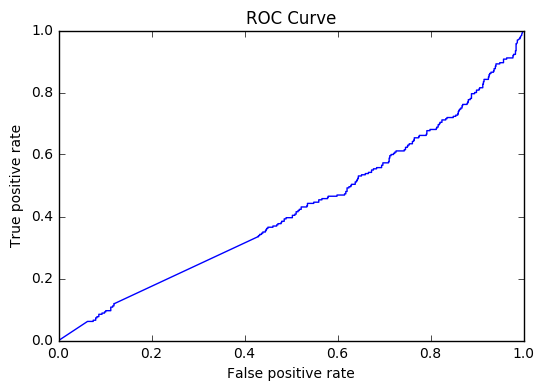

0.648409564818

Top 5 Weighted Features:
617
android askreddi iama 0.399758444708
7924
movies technolo todayile 0.491795926417
6325
iama karmacon 0.498969029177
6384
iama makeupad randomac wtf 0.515987143855
6308
iama jiffybot 0.648409564818


In [11]:
# get the best regularization
regStrength = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 6.0, 10.0]
vectorizer_p = TfidfVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,2))

tVector_p = vectorizer_p.fit_transform(data_preprocessor(trainCorpus))
dVector_p = vectorizer_p.transform(data_preprocessor(devCorpus))

for c in regStrength:
    modelLogit = LogisticRegression(penalty='l1', C=c)
    modelLogit.fit(tVector_p, trainLabel)
    logitScore = round(modelLogit.score(dVector_p, devLabel), 4)
    print("For C = ", c, "Logistic regression accuracy:", logitScore)
    score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression, C = 0.01')


# although the best score comes from c=.001, the bet F1-score 
# comes from c=.5, and this gives better weight options
modelLogit = LogisticRegression(penalty='l1', C=.5, tol = .1)
modelLogit.fit(tVector_p, trainLabel)
score_rep(devLabel,modelLogit.predict(dVector_p),'Logistic Regression')
roc_curve1(devLabel, modelLogit.predict_proba(dVector_p)[:,0])


print(max(modelLogit.coef_[0]))
numWeights = 5

sortIndex = np.argsort(modelLogit.coef_)
iLen = len(sortIndex[0])
print("\nTop", numWeights, "Weighted Features:")

for index in range((iLen - numWeights) , iLen):
    lookup = sortIndex[0][index]
    print(lookup)
    weight =  modelLogit.coef_[0][lookup]
    print(vectorizer.get_feature_names()[sortIndex[0][index]], weight)

# PCA/LDA to reduce dimension


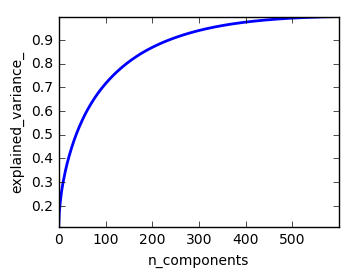

Random Forest
---------------------------------------------------------------------------
Accuracy:  0.735
Area under curve of ROC:  0.507848232848
Classification report:

             precision    recall  f1-score   support

      False       0.74      0.98      0.85       740
       True       0.39      0.03      0.06       260

avg / total       0.65      0.73      0.64      1000

---------------------------------------------------------------------------


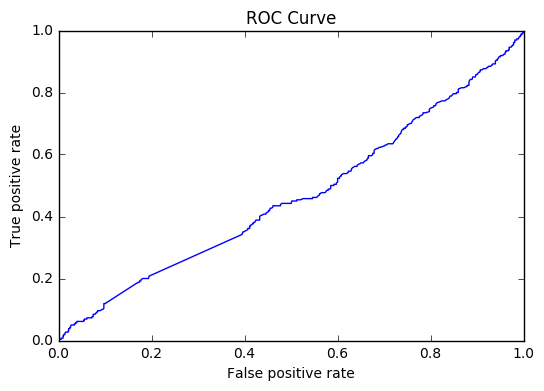

Naive Bayes, alpha = 0.01
---------------------------------------------------------------------------
Accuracy:  0.697
Area under curve of ROC:  0.535810810811
Classification report:

             precision    recall  f1-score   support

      False       0.76      0.87      0.81       740
       True       0.35      0.20      0.26       260

avg / total       0.65      0.70      0.67      1000

---------------------------------------------------------------------------


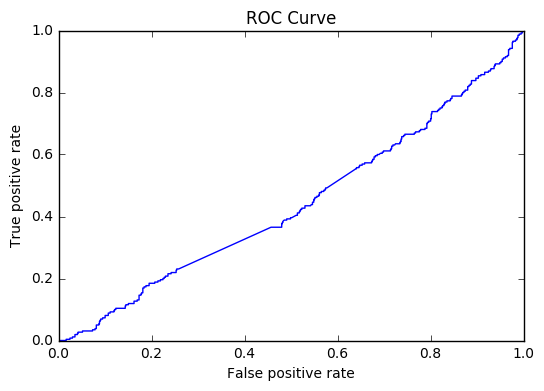

Logistic Regression, C = 0.01
---------------------------------------------------------------------------
Accuracy:  0.666
Area under curve of ROC:  0.516112266112
Classification report:

             precision    recall  f1-score   support

      False       0.75      0.83      0.79       740
       True       0.29      0.20      0.24       260

avg / total       0.63      0.67      0.64      1000

---------------------------------------------------------------------------


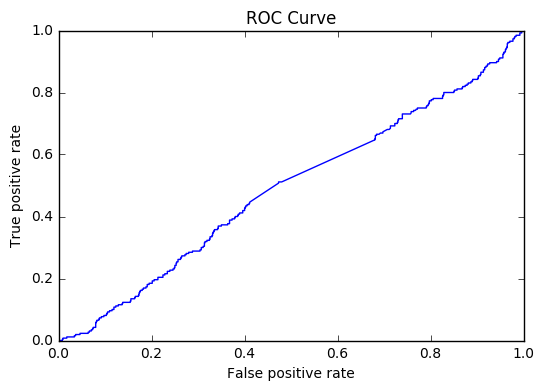

In [12]:
pca = TruncatedSVD(n_components=600)

vectorizer = CountVectorizer(min_df=2, max_df=0.95, lowercase=True, stop_words='english', 
                             strip_accents='unicode', ngram_range=(1,1))

tVector = vectorizer.fit_transform(data_preprocessor(trainCorpus))
dVector = vectorizer.transform(data_preprocessor(devCorpus))

#print(tVector.shape)

tVector_s = pca.fit(tVector)
dVector_s = pca.fit(dVector)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

RF = RandomForestClassifier(n_estimators=600)

RF.fit(tVector, trainLabel)
score_rep(devLabel, RF.predict(dVector),'Random Forest')
roc_curve1(devLabel, RF.predict_proba(dVector)[:,0])


alpha = 0.01

clf = BernoulliNB(alpha=alpha)

clf.fit(tVector, trainLabel)
score_rep(devLabel, clf.predict(dVector),'Naive Bayes, alpha = 0.01')
roc_curve1(devLabel, clf.predict_proba(dVector)[:,0])

C = 100 #(For now)

modelLogit = LogisticRegression(penalty='l2', C=C)

modelLogit.fit(tVector,trainLabel)
score_rep(devLabel,modelLogit.predict(dVector),'Logistic Regression, C = 0.01')
roc_curve1(devLabel, modelLogit.predict_proba(dVector)[:,0])


